## initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, block_diag
import ipywidgets as widgets
from tqdm import tqdm

In [2]:
import ukf_voss
import Assignment6

Metal device set to: Apple M2 Max
Using jax sqrtm for jax_sqrtm with backend  [METAL(id=0)]


W0000 00:00:1741532992.193518 11058639 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1741532992.206516 11058639 service.cc:145] XLA service 0x600000840000 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741532992.206528 11058639 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1741532992.207813 11058639 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1741532992.207823 11058639 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


In [3]:
u0 = np.array([
    [-0.1637, -0.2244, -0.1982, -0.1410, -0.1029, -0.0811, -0.0656, -0.0396],
    [-0.2593, -0.3580, -0.3021, -0.2008, -0.1321, -0.1028, -0.0840, -0.0516],
    [-0.2444, -0.3386, -0.2746, -0.1726, -0.0950, -0.0742, -0.0637, -0.0417],
    [-0.0055, -0.0383, 0.0012, -0.0657, -0.0395, -0.0388, -0.0387, -0.0270],
    [0.2361, 0.3685, 0.2616, 0.2237, 0.0279, -0.0174, -0.0239, -0.0183],
    [0.4698, 0.7002, 0.5627, 0.2726, 0.0939, -0.0071, -0.0171, -0.0135],
    [0.3618, 0.5613, 0.4323, 0.2754, 0.0673, -0.0056, -0.0130, -0.0104],
    [0.2442, 0.2669, 0.2571, 0.1067, 0.0152, -0.0049, -0.0077, -0.0061]
])

a0 = np.array([
    [0.4104, 0.5339, 0.4345, 0.2786, 0.1904, 0.1454, 0.1157, 0.0694],
    [0.7058, 0.9183, 0.6974, 0.4049, 0.2427, 0.1821, 0.1465, 0.0893],
    [0.9263, 1.1846, 0.8515, 0.4104, 0.1757, 0.1283, 0.1085, 0.0707],
    [1.0750, 1.4204, 1.0146, 0.4695, 0.0921, 0.0646, 0.0636, 0.0444],
    [1.0367, 1.4612, 0.9507, 0.4993, 0.0532, 0.0309, 0.0380, 0.0293],
    [0.7878, 1.1079, 0.7914, 0.3707, 0.0468, 0.0205, 0.0267, 0.0213],
    [0.4156, 0.5573, 0.4218, 0.1886, 0.0255, 0.0150, 0.0202, 0.0162],
    [0.1386, 0.1823, 0.1406, 0.0437, 0.0083, 0.0090, 0.0119, 0.0095]
])

i0 = np.concatenate((u0.ravel(), a0.ravel()))

## running the filter

In [4]:
noise_factor = 1.
obs_noise = 0.2 * np.sqrt(noise_factor)
nature0 = Assignment6.WilsonCowanNature(ll=800, dT=0.01, dt=0.001, initial_condition=i0, run_until=799, obs_noise=obs_noise)

In [5]:
noise_factor = 1
obs_noise = 0.2 * np.sqrt(noise_factor)

f = 8
g = 8
q = 0.015
variance_inflate = 1.3
# Q_par = np.diag([q, q])
Q_par0 = np.array([])
#Q_var0 = np.diag((nature.R * variance_inflate, ) * 2 * f * g)
Q_var0 = (variance_inflate
		  * np.cov(nature0.x0))
wilson_cowan_model = Assignment6.WilsonCowanModelWithParameterTracking(Q_par=Q_par0, Q_var=Q_var0, R=nature0.R)
uk_filter = ukf_voss.UKFVoss(model=wilson_cowan_model, ll=800, dT=0.01, dt=0.001, variance_inflation=1.02)
x_hat_orig, Pxx_orig, Ks_orig, errors_orig = uk_filter.filter(nature0.y, initial_condition=i0, run_until=799)

100%|██████████| 799/799 [00:44<00:00, 18.09it/s]


In [6]:
@widgets.interact(i=(0, 799 - 1))
def img_render(i=0):
	# fig, ax = plt.subplots(1, 3, figsize=(12, 8))
	plt.subplot(1, 3, 1)
	plt.imshow(nature0.x0[:64, i].reshape((8, 8)))
	plt.clim(0, nature0.x0[:64, :].max())

	plt.subplot(1, 3, 2)
	plt.imshow(x_hat_orig[:64, i].reshape((8, 8)))
	plt.clim(0, nature0.x0[:64, :].max())
	plt.subplot(1, 3, 3)
	plt.imshow(nature0.y[:64, i].reshape((8, 8)))
	plt.clim(0, nature0.x0[:64, :].max())

interactive(children=(IntSlider(value=0, description='i', max=798), Output()), _dom_classes=('widget-interact'…

## control without Kalman

In [10]:
# control without Kalman
noise_factor = 1
obs_noise = 0.2 * np.sqrt(noise_factor)
gain = -0.044
nature_ctrl_nok = Assignment6.WilsonCowanNature(ll=800, dT=0.01, dt=0.001, initial_condition=i0, run_until=100, obs_noise=obs_noise)
nature_no_ctrl = Assignment6.WilsonCowanNature(ll=1600, dT=0.01, dt=0.001, initial_condition=i0, run_until=800, obs_noise=obs_noise)

for n in range(100,799):
	nature_ctrl_nok.integrate_solveivp(run_until=n)
	nature_ctrl_nok.observations(n, n+1)
	nature_ctrl_nok.set_control(gain*nature_ctrl_nok.y[:,n])


In [9]:
nature = nature_ctrl_nok

@widgets.interact(i=(0, 799-1))
def img_render(i=0):
	plt.subplot(1, 2, 1)
	plt.imshow(nature.x0[:64,i].reshape((8,8)))
	plt.clim(0, nature.x0[:64,:].max())
	plt.subplot(1, 2, 2)
	plt.imshow(nature_ctrl_nok.x0[:64,i].reshape((8,8)))
	plt.clim(0, nature_ctrl_nok.x0[:64,:].max())

interactive(children=(IntSlider(value=0, description='i', max=798), Output()), _dom_classes=('widget-interact'…

## Control with Kalman

In [11]:
# control with Kalman
noise_factor = 1
obs_noise = 0.2 * np.sqrt(noise_factor)
# gain = 0.0003
gain = -0.015
variance_inflate = 2.
baseline_run = 800
total_duration = 7000
nature_no_ctrl = Assignment6.WilsonCowanNature(ll=total_duration, dT=0.01, dt=0.001, initial_condition=i0, obs_noise=obs_noise, run_until=total_duration-1)

nature_ctrl_k = Assignment6.WilsonCowanNature(ll=total_duration, dT=0.01, dt=0.001, initial_condition=i0, run_until=baseline_run, obs_noise=obs_noise)

Q_par = np.array([])
#Q_var0 = np.diag((nature.R * variance_inflate, ) * 2 * f * g)
Q_var = variance_inflate * np.cov(nature_ctrl_k.x0[:, :baseline_run])

wilson_cowan_model = Assignment6.WilsonCowanModelWithParameterTracking(Q_par=Q_par, Q_var=Q_var, R=nature_ctrl_k.R)
uk_filter = ukf_voss.UKFVoss(model=wilson_cowan_model, ll=total_duration, dT=0.01, dt=0.001, variance_inflation=40.)
x_hat0, Pxx0, Ks0, errors0 = uk_filter.filter(nature_ctrl_k.y, initial_condition=i0, run_until=baseline_run,
 												disable_progress=False)

100%|██████████| 800/800 [00:46<00:00, 17.11it/s]


In [12]:
for n in tqdm(range(baseline_run+1, total_duration-2)):
	nature_ctrl_k.integrate_solveivp(run_until=n)
	# control = gain*nature.y[:,n]
	control = gain * x_hat0[:64, n-1]
	nature_ctrl_k.set_control(control)
	wilson_cowan_model.set_control(control)
	x_hat0, Pxx0, Ks0, errors0 = uk_filter.filter(nature_ctrl_k.y, initial_condition=None, run_until=n,
												  disable_progress=True)

100%|██████████| 6197/6197 [06:04<00:00, 17.00it/s]


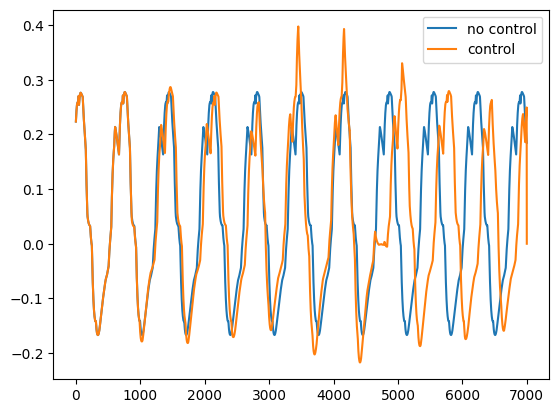

In [13]:
plt.plot(nature_no_ctrl.x0[35, :], label='no control')
plt.plot(nature_ctrl_k.x0[35, :], label='control')
plt.legend()

In [14]:
@widgets.interact(i=(0, total_duration - 2))
def img_render(i=0):
	# fig, ax = plt.subplots(1, 3, figsize=(12, 8))
	plt.subplot(1, 4, 1)
	plt.imshow(nature_ctrl_k.x0[:64, i].reshape((8, 8)))
	plt.clim(0, nature_no_ctrl.x0[:64, :].max())

	plt.subplot(1, 4, 2)
	plt.imshow(x_hat0[:64, i].reshape((8, 8)))
	plt.clim(0, nature_no_ctrl.x0[:64, i].max())
	plt.subplot(1, 4, 3)
	plt.imshow(nature_ctrl_k.y[:64, i].reshape((8, 8)))
	plt.clim(0, nature_no_ctrl.x0[:64, :].max())

	plt.subplot(1, 4, 4)
	plt.imshow(nature_no_ctrl.x0[:64, i].reshape((8, 8)))
	plt.clim(0, nature_no_ctrl.x0[:64, :].max())


interactive(children=(IntSlider(value=0, description='i', max=6998), Output()), _dom_classes=('widget-interact…

In [15]:
Pxx_tr = np.trace(Pxx0, axis1=0, axis2=1)

/var/folders/6z/lrk02sv52pn2vqxpttkyq1m00000gn/T/ipykernel_60802/2629936319.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(Pxx_tr))


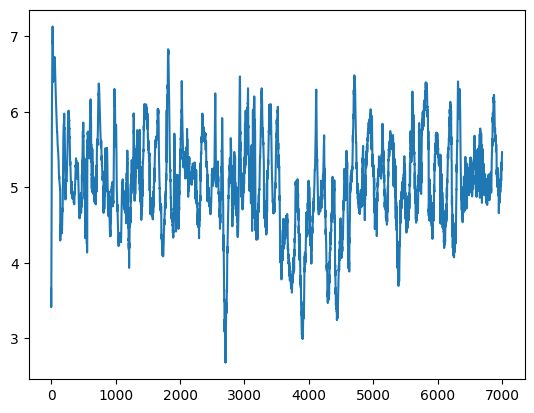

In [16]:
plt.plot(np.log(Pxx_tr))